In [21]:
import wandb
import matplotlib.pyplot as plt

from cleantext.sklearn import CleanTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import accuracy_score, classification_report, f1_score

from utils.data_utils import load_dataset_df

In [4]:
wandb.init(project="intent-detection", entity='nsoma')

wandb: Currently logged in as: nsoma. Use `wandb login --relogin` to force relogin


In [5]:
dataset = load_dataset_df()

dataset.head()

,text,intent,ds_name
0,is it simple to transfer money using my credit...,topping_up_by_card,valid
1,where did this fee come from?,extra_charge_on_statement,test
2,"since my pin is blocked, would you help me unb...",pin_blocked,test
3,with my credit card i would like to transfer m...,topping_up_by_card,valid
4,a transaction is showing more than once.,transaction_charged_twice,train


In [6]:
train_text = dataset[dataset.ds_name == "train"].text.tolist()
train_label = dataset[dataset.ds_name == "train"].intent.tolist()

test_text = dataset[dataset.ds_name == "test"].text.tolist()
test_label = dataset[dataset.ds_name == "test"].intent.tolist()

In [7]:
clean_trf = CleanTransformer(no_punct=False, lower=False)
le = LabelEncoder()

train_text_enc = clean_trf.transform(train_text)
test_text_enc = clean_trf.transform(test_text)

train_lbl_enc = le.fit_transform(train_label)
test_lbl_enc = le.transform(test_label)

wandb.log({"labels": list(le.classes_)})

In [8]:
text_clf_pipe = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', SGDClassifier()),
])

text_clf_pipe

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier())])

In [9]:
text_clf_pipe.fit(X=train_text_enc, y=train_lbl_enc)

pred_test_enc = text_clf_pipe.predict(test_text_enc)

In [10]:
accuracy_score(test_lbl_enc, pred_test_enc)

0.8811688311688312

In [11]:
param_grid = {
    "vect__stop_words": ['english', None],
    "vect__ngram_range": [(1,1), (1,2), (1,3)],
    "vect__min_df": [1, 0.01, 0.05, 0.1],
    "vect__max_df": [0.2, 0.5, 1.0],
    "tfidf__use_idf": [True, False],
    "clf__loss": ['hinge', 'log_loss'],
}

search = GridSearchCV(text_clf_pipe, param_grid, n_jobs=2)

In [12]:
search.fit(X=train_text_enc, y=train_lbl_enc)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=2,
             param_grid={'clf__loss': ['hinge', 'log_loss'],
                         'tfidf__use_idf': [True, False],
                         'vect__max_df': [0.2, 0.5, 1.0],
                         'vect__min_df': [1, 0.01, 0.05, 0.1],
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'vect__stop_words': ['english', None]})

In [13]:
search.best_params_

{'clf__loss': 'hinge',
 'tfidf__use_idf': True,
 'vect__max_df': 0.5,
 'vect__min_df': 1,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [14]:
best_estimator_pred = search.best_estimator_.predict(test_text_enc)

In [15]:
accuracy_score(test_lbl_enc, best_estimator_pred)

0.8814935064935064

In [16]:
print(classification_report(le.inverse_transform(test_lbl_enc),
                            le.inverse_transform(best_estimator_pred)))

                                                  precision    recall  f1-score   support

                           Refund_not_showing_up       0.90      0.95      0.93        40
                                activate_my_card       1.00      0.95      0.97        40
                                       age_limit       0.95      1.00      0.98        40
                         apple_pay_or_google_pay       0.98      1.00      0.99        40
                                     atm_support       0.86      0.93      0.89        40
                                automatic_top_up       1.00      0.97      0.99        40
         balance_not_updated_after_bank_transfer       0.72      0.78      0.75        40
balance_not_updated_after_cheque_or_cash_deposit       0.84      0.93      0.88        40
                         beneficiary_not_allowed       0.97      0.90      0.94        40
                                 cancel_transfer       0.93      0.95      0.94        40
         

/Users/somanagy/Library/Caches/pypoetry/virtualenvs/intent-detection-sBxw7ymE-py3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


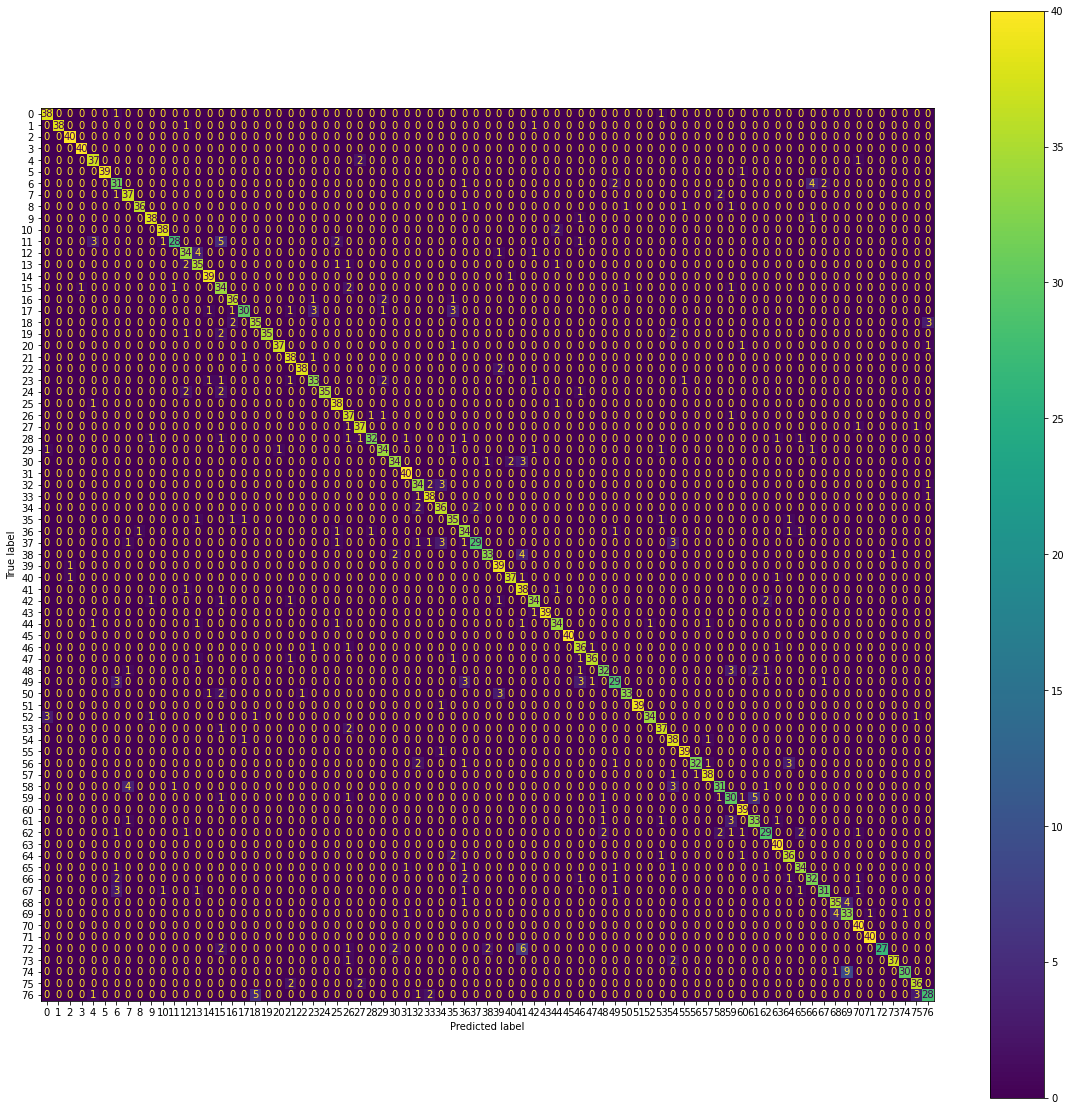

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))

plot_confusion_matrix(search.best_estimator_,
                      test_text_enc, test_lbl_enc,
                      ax=ax)  
plt.show()

In [18]:
wandb.sklearn.plot_class_proportions(train_lbl_enc, test_lbl_enc, list(le.classes_))

In [23]:
wandb.log({"test_accuracy": accuracy_score(test_lbl_enc, best_estimator_pred),
           "test_f1_score": f1_score(test_lbl_enc, best_estimator_pred, average='weighted')})

In [26]:
wandb.finish()

test_accuracy,▁
test_f1_score,▁
test_accuracy,0.88149
test_f1_score,0.88134
